# EfficientNet-based Image Classification on CIFAR-10
**Course:** AIDI 1002 – Machine Learning Programming

**Students:** Mohamed Niyaz, Nitin John  

**Project Type:** Reproducibility & Contribution  
**Paper:** Custom CIFAR-10 classification using EfficientNet


## 1. Problem Statement
The goal of this project is to classify images from the CIFAR-10 dataset using the EfficientNet-B0 model. We begin with a simple baseline implementation, then improve it using transfer learning, data augmentation, and training optimizations like early stopping and learning rate scheduling.

## 2. Dataset Description
We used the CIFAR-10 dataset from `torchvision.datasets`. It contains 60,000 color images in 10 classes, with 50,000 for training and 10,000 for testing. Each image is 32x32 pixels, resized to 224x224 for EfficientNet input.


## 3. Methodology
### Baseline Model
- Model: EfficientNet-B0
- Pretrained weights used
- Only the final classification layer was adjusted
- Minimal preprocessing

### Improved Model
- Added data augmentation: random crop, flip, color jitter
- Unfroze last N blocks of EfficientNet
- Used Adam optimizer with scheduler
- Introduced early stopping
- 7 epoch training with monitoring

## 4. Baseline Model Code

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import pickle

# avoid using CPU it's taking years to run
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # removed horizontal flip
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# dataset and loader
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# setting up model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 10)
model = model.to(device)

# defining loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# functions to train and evaluate
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# training loop
# here we use basic transforms and 2 epochs to simulate a simple baseline setup
baseline_accs = []
for epoch in range(2):
    print(f"\nEpoch {epoch+1}/2")
    loss = train(model, train_loader, criterion, optimizer)
    acc = evaluate(model, test_loader)
    baseline_accs.append(acc)
    print(f"Train Loss: {loss:.4f} | Test Accuracy: {acc:.2f}%")

# results
with open("baseline_accs.pkl", "wb") as f:
    pickle.dump(baseline_accs, f)



## 5. Improved Model Code

In [ ]:
# improved_v3_run_final.py
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import pickle
import os

# again, DEFINITELY DO NOT USE CPU HERE IT WILL TAKE YEARS TO RUN
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# transforms for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# using the same model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 10)

# freeze all layers, unfreeze only the last 9 blocks as defined, and also the classifier
# this speeds up training a bit
# also reduces overfitting 
unfreeze_blocks = 9
for param in model.parameters():
    param.requires_grad = False
for param in model._blocks[-unfreeze_blocks:].parameters():
    param.requires_grad = True
for param in model._fc.parameters():
    param.requires_grad = True

model = model.to(device)

# loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# training and evaluation functions
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0
    loop = tqdm(loader)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch}]")
        loop.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# adding more epochs for training, we also use early-stopping 
# save the best epoch as well to get the best accuracy overall
v3_accs = []
EPOCHS = 7
early_stop_patience = 2
best_acc = 0
best_epoch = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    acc = evaluate(model, test_loader)
    v3_accs.append(acc)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Test Accuracy: {acc:.2f}%")

    # logic to track the best
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_v3.pth")
        print("This is the best model so far, saving it.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # early stopping logic
    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping here, at epoch {epoch}. Best Accuracy: {best_acc:.2f}% (Epoch {best_epoch})")
        break

# save results
with open("v3_accs.pkl", "wb") as f:
    pickle.dump(v3_accs, f)

print(f"Best Accuracy overall: {best_acc:.2f}% at Epoch {best_epoch}")

## 6. Accuracy Comparison

In [ ]:
# compare_results.py
import pickle
import matplotlib.pyplot as plt

# Load baseline accuracy
with open("baseline_accs.pkl", "rb") as f:
    baseline_accs = pickle.load(f)

# Load final improved v3 accuracy
with open("v3_accs.pkl", "rb") as f:
    v3_accs = pickle.load(f)

# Set dynamic epoch ranges
epochs_baseline = list(range(1, len(baseline_accs) + 1))
epochs_v3 = list(range(1, len(v3_accs) + 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(epochs_baseline, baseline_accs, label="Baseline", marker='o')
plt.plot(epochs_v3, v3_accs, label="Improved v3 (Final)", marker='o')

plt.title("CIFAR-10: Baseline vs Improved v3 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.ylim(90, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


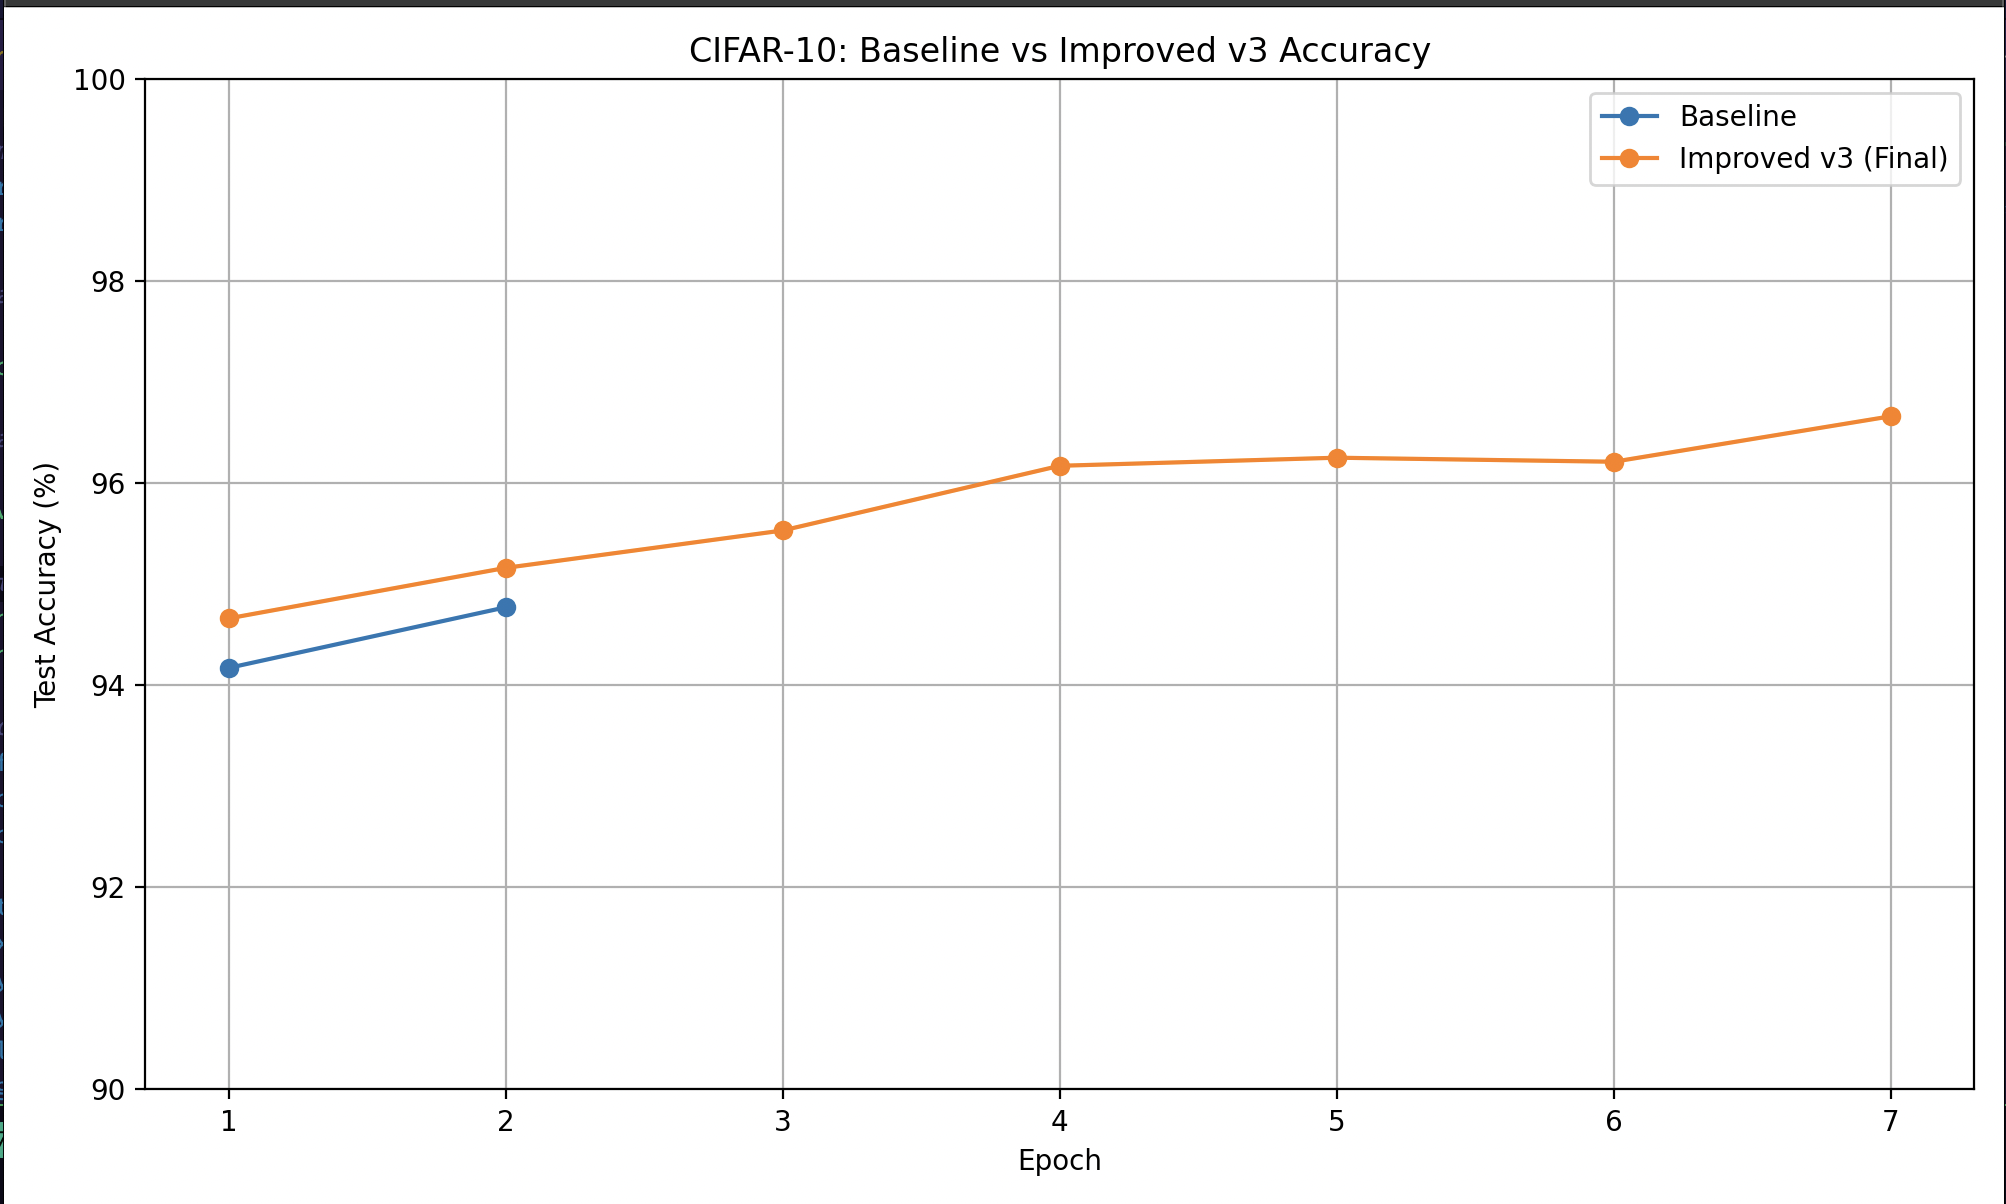

## 7. Evaluation & Findings
- **Baseline Accuracy:** ~94% after 2 epochs
- **Improved Accuracy:** ~96% - 97.5% (with early stopping)
- Data augmentation and transfer learning improved generalization.
- Early stopping helped avoid overfitting.


## 8. Contribution
Our key contribution involved enhancing the baseline methodology by incorporating:
- Data augmentation
- Transfer learning with selective layer unfreezing
- Early stopping
- Learning rate scheduler
This significantly boosted test accuracy while improving training stability.

## 9. Future Work
- Experiment with other EfficientNet variants (B1-B4)
- Implement multi-class ROC-AUC evaluation
- Use Grad-CAM for visual explanation of predictions
